<a href="https://colab.research.google.com/github/andretocci/notebooks/blob/master/Post_blog_Attribution(MAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demostração Blog DP6

Importando pacotes necessários:

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install marketing_attribution_models
from marketing_attribution_models import MAM

In [0]:
#@title Importando e Tratando as Bases
import glob
from google.colab import drive
drive.mount('/content/drive/')

filepath = '/content/drive/Shared drives/Data Science/Ultron/Recipes/DP6tribution/'
filename = '*'
all_files = glob.glob(filepath + filename)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Para está demonstração, optamos por demonstrar utilizando uma base de dados bastante conhecida pelos profissionais do Marketing: Google Merchandise Store. Está base foi extraída da conta de demonstração do Google Analytics, que pode ser acessada por qualquer usuário do Google.

In [0]:
#Lendo os dados do Google Merchandise Store, mas selecioanndo apenas as colunas que serão utilizadas para gerar os modelos
df = pd.read_csv(all_files[0], 
                 usecols=['channelGrouping', 
                          'date', 
                          'fullVisitorId', 
                          'totals_transactions', 
                          'totals_transactionRevenue'],
                 dtype = {'channelGrouping':str, 
                          'fullVisitorId':str, 
                          'totals_transactions' : np.float64, 
                          'totals_transactionRevenue' : np.float64} )

#Analizando o DF retornado
df.head()

,channelGrouping,date,fullVisitorId,totals_transactions,totals_transactionRevenue
0,Organic Search,20171016,579247845938461901,nan,nan
1,Organic Search,20171016,875141984250977091,nan,nan
2,Organic Search,20171016,953429090981710815,nan,nan
3,Organic Search,20171016,2365540140634612791,nan,nan
4,Organic Search,20171016,8585866264807101623,nan,nan


Mas antes de aplicarmos o modelo utilizando a MAM, precisamos realizar alguns ajustes na base de dados. 

E analisando o .head() e o .info(), conseguimos observar que:

- A coluna de data não está no formato datetime;
- As colunas totals_transactions e totals_transactionRevenue possuem valores vazios;
- fullVisitorId foi lido como objeto, temos que tomar cuidado para não ler essa informação como número, 001 pode ser um ID diferente de1; 
- A base não possui nenhum agrupamento de jornada;

In [0]:
#Selecionando colunas necessárias
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73948 entries, 0 to 73947
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   channelGrouping            73948 non-null  object 
 1   date                       73948 non-null  int64  
 2   fullVisitorId              73948 non-null  object 
 3   totals_transactions        818 non-null    float64
 4   totals_transactionRevenue  817 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.8+ MB


Assim, tratamos a coluna de data para o formato correto, tratamos os valores nulos e criamos uma coluna indicando se houve ou não uma conversão naquela sessão.

In [0]:
df['date_tratada']  = pd.to_datetime( df['date'], format='%Y%m%d' )
df['totals_transactions'].fillna(0, inplace=True)
df['totals_transactionRevenue'].fillna(0, inplace=True)
df['has_transaction'] = df.totals_transactions.apply(lambda x: True if x > 0 else False)

df.head()

,channelGrouping,date,fullVisitorId,totals_transactions,totals_transactionRevenue,date_tratada,has_transaction
0,Organic Search,20171016,579247845938461901,0.000,0.000,2017-10-16,False
1,Organic Search,20171016,875141984250977091,0.000,0.000,2017-10-16,False
2,Organic Search,20171016,953429090981710815,0.000,0.000,2017-10-16,False
3,Organic Search,20171016,2365540140634612791,0.000,0.000,2017-10-16,False
4,Organic Search,20171016,8585866264807101623,0.000,0.000,2017-10-16,False


Agora que tratamos nossa base, podemos criar o nosso objeto MAM, como nossa base está na granularidade de sessão por usuário e não possuímos um ID de agrupamento de jornada, é importante que passamos como True os parametros group_channels e create_journey_id_based_on_conversion.

In [0]:
DP_tribution = MAM(df, 
                  channels_colname='channelGrouping',
                  group_channels=True, 
                  group_channels_by_id_list=['fullVisitorId'], 
                  group_timestamp_colname='date_tratada',
                  journey_with_conv_colname='has_transaction',
                  create_journey_id_based_on_conversion = True,
                  conversion_value='totals_transactionRevenue')

Acessando o atributo .DataFrame, conseguimos observar que houve uma mudança significativa em nossa base de dados. Observamos que a granularidade da tabela foi alterada de sessão para jornada e que há uma coluna nova de id da jornada.

In [0]:
DP_tribution.DataFrame.sort_values('conversion_value', ascending=False).head()

,journey_id,channels_agg,converted_agg,conversion_value,time_till_conv_agg
12649,id:2969957690756250633_J:0,Organic Search > Organic Search > Organic Sear...,True,4198500000.000,72.0 > 48.0 > 24.0 > 0.0
48276,id:8539433516671325668_J:0,Direct > Direct > Direct > Direct > Direct > D...,True,2870000000.000,48.0 > 48.0 > 24.0 > 24.0 > 0.0 > 0.0 > 0.0
12230,id:2904329822175970539_J:4,Referral > Referral > Referral,True,2578500000.000,600.0 > 288.0 > 0.0
41360,id:7445235885559107095_J:3,Organic Search > Organic Search > Organic Sear...,True,2490000000.000,768.0 > 408.0 > 288.0 > 264.0 > 264.0 > 96.0 >...
26992,id:5183829074529712735_J:0,Direct > Direct > Direct,True,1919200000.000,0.0 > 0.0 > 0.0


### Aplicando os Modelos

Para rodar o modelo do Shapley Value, basta aplicar o método .attribution_shapley().

O parâmetro **size limita quantidade de canais únicos na jornada**, por **padrão** é definido como os **4 últimos**. Isso ocorre pois o número de iterações aumenta exponencialmente com o número de canais. Da ordem de 2N, sendo N o número de canais.   

A metodologia do cálculo das contribuições marginais pode variar através do **parâmetro order**, que por padrão calcula a contribuição da **combinação dos canais independende da ordem em que aparecem** nas diferentes jornadas.

Por fim, parâmetro na qual o Shapley Value será calculado pode ser alterado em **values_col**, que por padrão utiliza a **taxa de conversão** que é uma forma de **considerarmos as não conversões no cálculo do modelo**. Contudo, também podemos considerar no cálculo o total de conversões ou o valor gerados pelas conversões, como demostrado abaixo. 

In [0]:
shapley_results = DP_tribution.attribution_shapley()

O método retorna uma tupla contendo :
- Os resultados agrupados por jornadas únicas;

In [0]:
shapley_results[0]

,combinations,conversions,total_sequences,conversion_value,conv_rate,attribution_shapley_size4_conv_rate_algorithmic
16,Direct,157,8647,29708520000.000,0.018,[29708520000.0]
17,Direct > Display,2,13,442590000.000,0.154,"[243368413.16711098, 199221586.83288905]"
18,Direct > Display > Organic Search,1,6,33980000.000,0.167,"[15685297.311649714, 14457030.40197919, 383767..."
21,Direct > Organic Search,9,210,1812070000.000,0.043,"[1086350193.20019, 725719806.79981]"
24,Direct > Organic Search > Referral,3,28,1410520000.000,0.107,"[334937900.0109693, 179302753.22538412, 896279..."
28,Direct > Referral,22,221,5895830000.000,0.100,"[1653725008.2510033, 4242104991.7489963]"
31,Display,4,1423,238200000.000,0.003,[238200000.0]
32,Display > Organic Search,3,65,133890000.000,0.046,"[57058012.82148681, 76831987.1785132]"
35,Display > Organic Search > Referral,1,7,26400000.000,0.143,"[7391834.050253105, 2623250.57365777, 16384915..."
38,Display > Referral,3,21,114210000.000,0.143,"[33501108.56390939, 80708891.43609062]"


- E os resultados agrupados por canais:

In [0]:
shapley_results[1].reset_index()

,channels,value
0,Direct,33042586811.941
1,Display,549829572.671
2,Organic Search,27222295557.146
3,Paid Search,2718002172.263
4,Referral,49310895885.980
5,Social,61080000.000


Para rodar o modelo das **Cadeias de Markov**, basta aplicar o método .attribution_markov().

No parâmetro de entrada transition_to_same_state, indica se irá ser retornado ou não a probabilidade de transição para o mesmo estado. Essa configuração **não afeta os resultados agregados** e que são atribuídos para cada canal, **mas sim os valores observados na matriz de transição**.

In [0]:
markov_results = DP_tribution.attribution_markov(transition_to_same_state=False)

O método retorna uma tupla contendo :
- Os resultados em nível de jornada, que também pode ser obeservado acessando o .DataFrame. 

In [0]:
markov_results[0].head()

0    [1.0]
1    [1.0]
2    [1.0]
3    [1.0]
4    [1.0]
Name: channelGrouping, dtype: object

- E os resultados agrupados por canais, como retornado pelo modelo Shapley acima;

In [0]:
markov_results[1]

,channels,attribution_markov_algorithmic
0,Display,859295618.089
1,Affiliates,0.000
2,(Other),0.000
3,Organic Search,29002939438.611
4,Referral,46028648315.510
5,Social,52278245.740
6,Direct,33804951171.975
7,Paid Search,3156577210.076


- Matrix de transição:

In [0]:
ax, fig = plt.subplots(figsize=(15,10))
sns.heatmap(markov_results[2].round(3), cmap="YlGnBu", annot=True, linewidths=.5)

- **Removal Effect**, quarto output dos resultados attribution_markov, que como detalhado anteriormente, nos auxilia a entender a impertância de cada canal analisado:

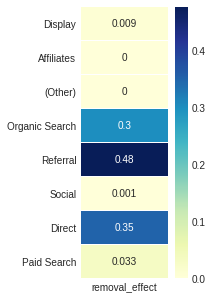

In [0]:
ax, fig = plt.subplots(figsize=(2,5))
sns.heatmap(markov_results[3].round(3), cmap="YlGnBu", annot=True, linewidths=.5)

#### Comparando os Resultados

Agora que rodamos ambos os modelos, podemos comparar seus resultados acessando o atributo group_by_channels_models, que retorna todos os diferentes modelos aplicados nos passos anteriores.

In [0]:
DP_tribution.group_by_channels_models

,channels,attribution_shapley_size4_conv_rate_algorithmic
0,Direct,31496838188.688
1,Display,687694045.990
2,Organic Search,27527663233.955
3,Paid Search,2830265750.282
4,Referral,50301148781.086
5,Social,61080000.000


In [0]:
DP_tribution.group_by_channels_models.sum()

channels                                           DirectDisplayOrganic SearchPaid SearchReferral...
attribution_shapley_size4_conv_rate_algorithmic                                          1.12905e+11
attribution_markov_algorithmic                                                           1.12905e+11
dtype: object

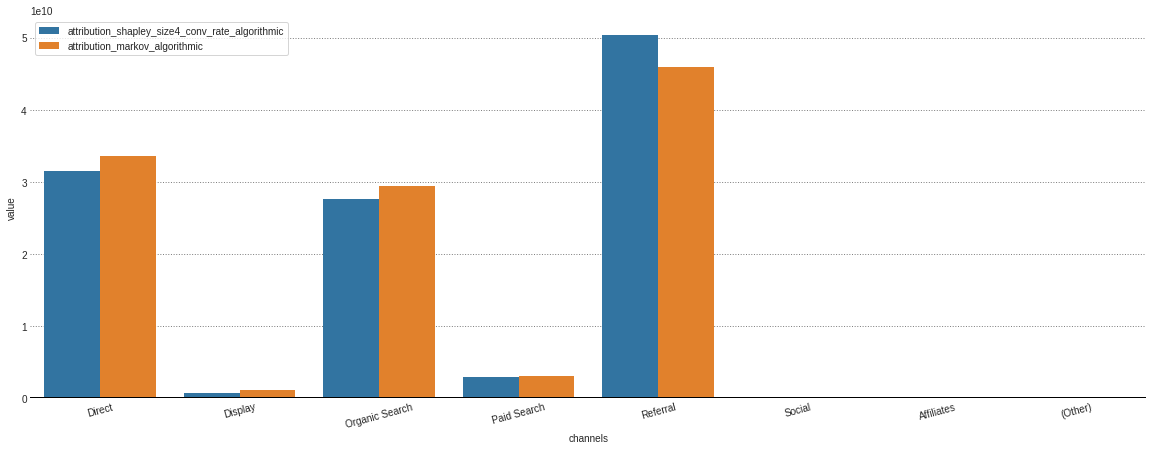

In [0]:
 DP_tribution.plot()